In [ ]:
import numpy as np
import string
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

Definition of a plot function for training result visualization

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show();

## Data preprocessing

In [ ]:
# Mounting the google drive to google colab in order to load the data files directly from it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We load a dataset build from Europarl dataset (containing the proceedings from the European Parliament in different languages). We will use a cleaned version of both english and french sentences (each sentence english sentence sharing the same meaning as corresponding french one)

In [ ]:
import pickle
with open(f'/content/drive/MyDrive/EPITA_NLP/Course3/english.pkl', 'rb') as f:
    data_eng = pickle.load(f)
df_eng = pd.DataFrame(data_eng)

with open(f'/content/drive/MyDrive/EPITA_NLP/Course3/french.pkl', 'rb') as f:
    data_fren = pickle.load(f)
df_fren = pd.DataFrame(data_fren)

In [ ]:
count = 0

data_fren = []
data_eng = []
for i, row in df_eng.iterrows():
    if count > 5000:
        break;
    fr_row = df_fren.loc[i]
    if len(row[0].split()) <= 8 and len(fr_row[0].split()) <= 8:
        data_fren.append(fr_row[0])
        data_eng.append(row[0])
        count += 1

In [ ]:
df_fren = pd.DataFrame(data_fren)
df_eng = pd.DataFrame(data_eng)

We can have a look on the english dataset

In [ ]:
df_eng

,0
0,resumption of the session
1,madam president on a point of order
2,madam president on a point of order
3,it is the case of alexander nikitin
4,mr berenguer fuster we shall check all this
...,...
4996,the vote will take place tomorrow at pm
4997,chinas accession to wto
4998,so the results are clear
4999,will it result in institutional reforms in china


As well as on the French dataset

In [ ]:
df_fren

,0
0,reprise de la session
1,madame la presidente cest une motion de procedure
2,madame la presidente cest une motion de procedure
3,il sagit du cas dalexandre nikitin
4,cher collegue nous allons verifier tout cela
...,...
4996,le vote aura lieu demain a heures
4997,adhesion de la chine a lomc
4998,le resultat est donc appreciable
4999,des reformes institutionnelles interviendronte...


We can check both datasets correspond to the same sentences in both languages.

(You can see that the cleaning step had some impacts on some French words, especially concerning the accents which have been removed. Anyway, this is not a big problem here since we do not use a pre-trained model for language understanding, we use these French sentences as references for training a model from scratch)

In [ ]:
for en_sent, fr_sent in list(zip(df_eng[0],df_fren[0]))[0:3]:
  print(f"English: {en_sent}")
  print(f"French: {fr_sent}")
  print("---------------------")

English: resumption of the session
French: reprise de la session
---------------------
English: madam president on a point of order
French: madame la presidente cest une motion de procedure
---------------------
English: madam president on a point of order
French: madame la presidente cest une motion de procedure
---------------------


We define the Tokenizer object for both languages, and we get the size of vacabulary found in each.

We also define the size of the sequences we want to use for training (we can keep a reduce length to speed up training)

In [ ]:
# prepare english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(df_eng[0][:50000])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('Size of English Vocabulary : %d' % eng_vocab_size)
# prepare French tokenizer
fren_tokenizer = Tokenizer()
fren_tokenizer.fit_on_texts(df_fren[0][:50000])
fren_vocab_size = len(fren_tokenizer.word_index) + 1
fren_length = 8
print('Size of French Vocabulary : %d' % fren_vocab_size)

Size of English Vocabulary : 3462
Size of French Vocabulary : 4378


We transform the text sentences into token sequences.

We also add zero-padding for each of those sequences. Since we consider rather small length, most of the time the sequences will be troncated instead of being completed with additional zeros)

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in df_eng[0][:5000]:
	token_list = eng_tokenizer.texts_to_sequences([line])[0]
	input_sequences.append(token_list)


# pad sequences
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences_eng = np.array(pad_sequences(input_sequences, maxlen=eng_length, padding='post'))

For the fist sentence of the dataset, we can see the padded-zeros in the end

In [ ]:
print(f"sentence => {df_eng[0][0]}")
print(f"token sequence => {input_sequences_eng[0]}")
print(f"sequence length => {len(input_sequences_eng[0])}")

sentence => resumption of the session
token sequence => [272   7   1 151   0   0   0   0]
sequence length => 8


For the others, most of the time, the sequence is troncated. Anyway, you can check that the length of the **padded sequence** is always the same.

In [ ]:
print(f"sentence => {df_eng[0][1]}")
print(f"token sequence => {input_sequences_eng[1]}")
print(f"sequence length => {len(input_sequences_eng[1])}")

sentence => madam president on a point of order
token sequence => [193  41  27   9  61   7 162   0]
sequence length => 8


We do the exact same processing but this time to turn the **French** sentences into padded token sequences.

In [ ]:
# create input sequences using list of tokens
input_sequences = []
for line in df_fren[0][:5000]:
	token_list = fren_tokenizer.texts_to_sequences([line])[0]
	input_sequences.append(token_list)


# pad sequences
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences_fren = np.array(pad_sequences(input_sequences, maxlen=fren_length, padding='post'))

In [ ]:
input_sequences_fren[0]

array([268,   3,   2, 136,   0,   0,   0,   0], dtype=int32)

In [ ]:
fren_vocab_size

4378

## Neural network model definition

Build a neural network using at least one LSTM layer

(you may have a look at https://keras.io/api/layers/)


In [ ]:
model = Sequential()
model.add(Embedding(eng_vocab_size, 512, input_length=eng_length, mask_zero=True))
model.add(LSTM(512))
#------------------------- Choose either the RepeatVector of the Bidirectional
model.add(RepeatVector(fren_length))
#model.add(Bidirectional(LSTM(fren_length), return_sequences = True))
#----------------------------
model.add(LSTM(512, return_sequences=True))
model.add(Dense(fren_vocab_size, activation='softmax'))


#rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',  metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 512)            1772544   
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 8, 512)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense_1 (Dense)             (None, 8, 4378)           2245914   
                                                                 
Total params: 8,216,858
Trainable params: 8,216,858
Non-trainable params: 0
____________________________________________

In [ ]:
history = model.fit(x = input_sequences_eng, y = input_sequences_fren, epochs = 30, batch_size= 100, validation_split=0.25)

Epoch 1/30
38/38 [==============================] - 52s 1s/step - loss: 5.9811 - accuracy: 0.3218 - val_loss: 5.0459 - val_accuracy: 0.3413
Epoch 2/30
38/38 [==============================] - 41s 1s/step - loss: 4.7638 - accuracy: 0.3411 - val_loss: 4.7740 - val_accuracy: 0.3586
Epoch 3/30
38/38 [==============================] - 42s 1s/step - loss: 4.5339 - accuracy: 0.3442 - val_loss: 4.7474 - val_accuracy: 0.3591
Epoch 4/30
38/38 [==============================] - 41s 1s/step - loss: 4.4134 - accuracy: 0.3459 - val_loss: 4.7074 - val_accuracy: 0.3614
Epoch 5/30
38/38 [==============================] - 40s 1s/step - loss: 4.3059 - accuracy: 0.3519 - val_loss: 4.6787 - val_accuracy: 0.3676
Epoch 6/30
38/38 [==============================] - 41s 1s/step - loss: 4.2048 - accuracy: 0.3533 - val_loss: 4.6683 - val_accuracy: 0.3660
Epoch 7/30
38/38 [==============================] - 41s 1s/step - loss: 4.1164 - accuracy: 0.3578 - val_loss: 4.6829 - val_accuracy: 0.3677
Epoch 8/30
38/38 [==

In [ ]:
def translate(input):
    predicted = model.predict(input, verbose=0)
    output_words = ""
    for token_predicted in predicted[0]:
        for word, index in fren_tokenizer.word_index.items():
            if index == token_predicted.argmax():
                output_words += word+" "
                break
    return output_words

for i in range(10):
    input_sentence = df_eng.loc[i][0]
    token_list_test = eng_tokenizer.texts_to_sequences([input_sentence])[0]
    input_sequences_eng_test = np.array(pad_sequences([token_list_test], maxlen=eng_length, padding='post'))
    print(input_sentence)
    print(translate(input_sequences_eng_test))
    print(df_fren.loc[i][0])
    print('------------')

resumption of the session
reprise de la session 
reprise de la session
------------
madam president on a point of order
monsieur la president la la de de procedure 
madame la presidente cest une motion de procedure
------------
madam president on a point of order
monsieur la president la la de de procedure 
madame la presidente cest une motion de procedure
------------
it is the case of alexander nikitin
il est un un 
il sagit du cas dalexandre nikitin
------------
mr berenguer fuster we shall check all this
je ai et et et et 
cher collegue nous allons verifier tout cela
------------
we do not know what is happening
nous ne pouvons pas pas pas pas 
nous ne savons pas ce qui se passe
------------
agenda
ordre de travaux 
ordre des travaux
------------
relating to wednesday
en ce qui concerne la mercredi 
en ce qui concerne le mercredi
------------
applause from the pse group
applaudissements a groupe pse 
applaudissements du groupe pse
------------
parliament rejected the request presid

In [ ]:
predict = model.predict(input_sequences_eng[0].reshape(1,8), verbose=0)
np.argmax(predict,axis=1)

array([[7, 2, 2, ..., 0, 0, 0]])

In [ ]:
input_sequences_eng[0].shape

(8,)

We can define an English sentence to be translated into French thanks to the model trained

In [ ]:
input_sentence = "resumption of the session"
token_list_test = eng_tokenizer.texts_to_sequences([input_sentence])[0]


# pad sequences
#max_sequence_len = max([len(x) for x in input_sequences])
input_sequences_eng_test = np.array(pad_sequences([token_list_test], maxlen=eng_length, padding='post'))

We compute the translation

In [ ]:
translate( input_sequences_eng_test)

'reprise de la session '

## Result visualization

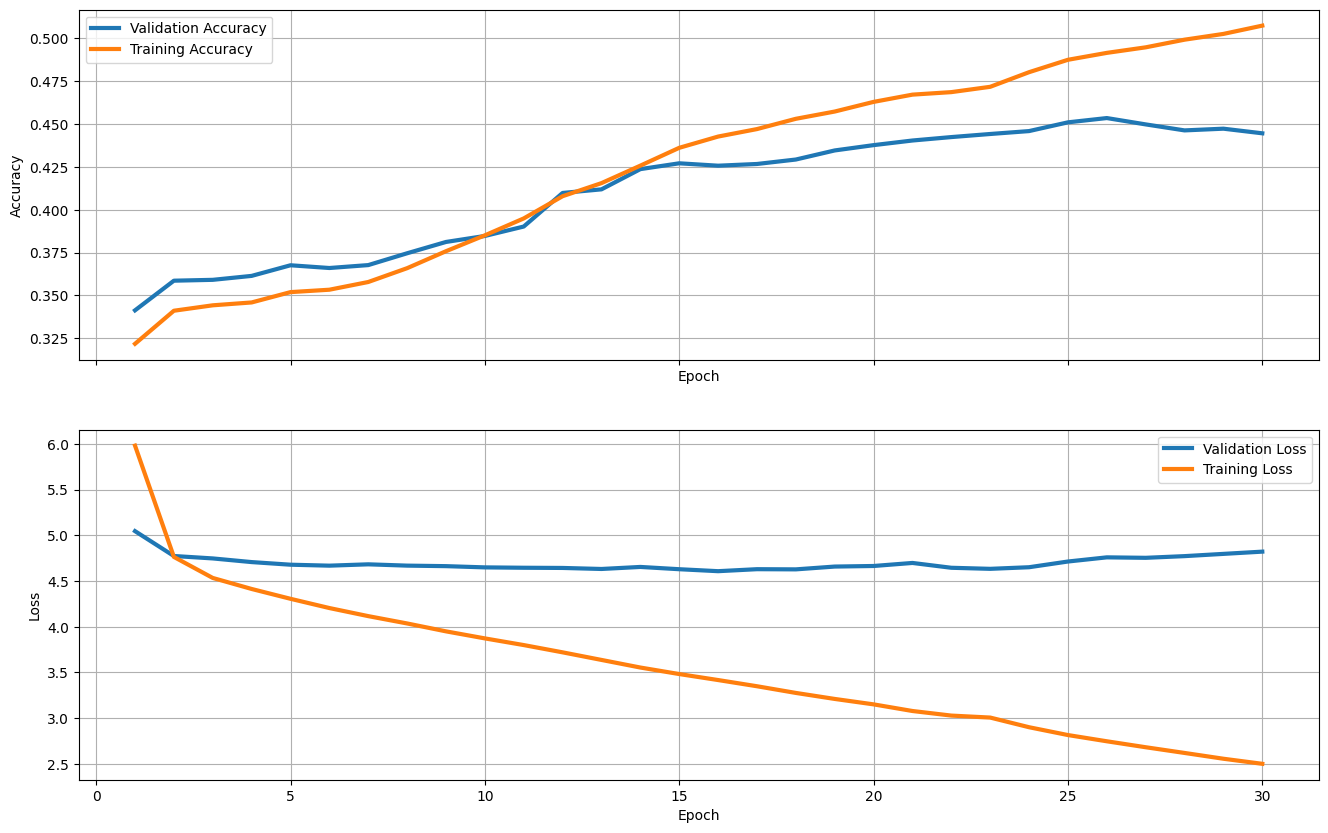

In [ ]:
plot_results(history)

**References:**

The approach and the model architecture come mainly from

  https://medium.com/@saikrishna4820/lstm-language-translation-18c076860b23

and has been adapted to work in this English-French translation use case (instead of an English-Hindi one) by **Eli Yaacoub** (EPITA student in 2022)

The dataset comes from

https://machinelearningmastery.com/prepare-french-english-dataset-machine-translation/